In [ ]:
import nltk
nltk.download('nps_chat')

[nltk_data] Downloading package nps_chat to /root/nltk_data...
[nltk_data]   Unzipping corpora/nps_chat.zip.


True

In [ ]:
from nltk.corpus import nps_chat
from sklearn.model_selection import train_test_split
from tensorflow import keras as k
import tensorflow as tf
import numpy as np
import re

In [ ]:
nps_chat.tagged_posts()

[[('now', 'RB'), ('im', 'PRP'), ('left', 'VBD'), ('with', 'IN'), ('this', 'DT'), ('gay', 'JJ'), ('name', 'NN')], [(':P', 'UH')], ...]

In [ ]:
def filters(punc=True):
    def inner_filters(x):
        punctuation = r"\^\.|[\.|\`|:|,|\)|\(|\"|\']+"
        condition = [x[0].strip() , x[1].strip()]
        if punc:
            condition.append(not(re.match(punctuation, x[0].strip())))
            condition.append(not(re.match(punctuation, x[1].strip())))
        return  all(condition)

    return inner_filters
    
data = [list(filter(filters(True) , sentence)) for sentence in nps_chat.tagged_posts()]
data = list(filter(lambda vec:len(vec),data)) # remove empty lists

In [ ]:
def seq_to_int(data,set_of_words,index_shift=1,padding=True):
    mapper = dict(map(lambda x: x[::-1], enumerate(set_of_words))) # map each word to it's indices

    def word2int(vec):
        if not isinstance(vec[0],list):
            return [mapper[word]+ index_shift if word in mapper.keys() else 1 for word in vec]
        # map each word to an integer, 1 for OOV (out of vocab)
        return list(map(word2int,vec))
        
    mapped_data = list(map(word2int, data))
    if padding:
        mapped_data=k.preprocessing.sequence.pad_sequences(mapped_data, padding= 'post') # pad 2D sentences with 0
    return mapped_data

In [ ]:
vocab = [w.lower() for w in nps_chat.words()]
vocab = list(set(vocab)) # create set of words
sentences = [[tup[0].lower() for tup in sentence] for sentence in data] # extract training data from corpus

n= int(len(sentences)/10)
test_data = sentences[:n]
train_word  = sentences[n:]

train_word  = np.array(seq_to_int(train_word ,vocab, index_shift=2, padding=True))
test_data = seq_to_int(test_data, vocab, index_shift=2, padding=False) # no padding for test data

print("train_word",train_word.shape)
print("test_data",len(test_data))

train_word (9430, 72)
test_data 1047


In [ ]:
# there is 2 version of this step, look at the bellow cell 
chars = [[list(word) for word in sentence] for sentence in sentences]
char_set = [chr(i) for i in range(32,127)]
chars = seq_to_int(chars, char_set, index_shift=1, padding=False)

# padding 3D ragged list of chars
# shape of padded chars should be: (number_of_sentences, length of padded sentence, maximum length of words)
padded_chars = np.zeros((len(sentences), train_word.shape[1], max(map(len, vocab)))) 

level_len = [[len(word_level) for word_level in sentence_level] for sentence_level in chars] # length of inner list: each word
level_len = k.preprocessing.sequence.pad_sequences(level_len, padding= 'post') # we must also padd length-array
mask = np.arange(padded_chars.shape[-1]) < np.array(level_len)[:, :, None]
padded_chars[mask] = sum(sum(chars, []), [])
train_chars = padded_chars[n:]
test_chars = padded_chars[:n]
print("train_chars",train_chars.shape)

train_chars (9430, 72, 70)


In [ ]:
# different version of above cell. here we cutout each word to have 10 chars at most. and padd the other words to have 10 chars
chars = [[list(word)[:10] for word in sentence] for sentence in sentences] #  we take 10 first chars of each word
char_set = [chr(i) for i in range(32,127)] # charset of ASCI chars
chars = seq_to_int(chars, char_set, index_shift=1, padding=False)

# padding 3D ragged list of chars
# shape of padded chars should be: (number_of_sentences, length of padded sentence, maximum length of words)
padded_chars = np.zeros((len(sentences), train_word.shape[1], 10))

level_len = [[len(word_level) for word_level in sentence_level] for sentence_level in chars] # length of inner list: each word
level_len = k.preprocessing.sequence.pad_sequences(level_len, padding= 'post') # we must also padd length-array
mask = np.arange(padded_chars.shape[-1]) < np.array(level_len)[:, :, None]
padded_chars[mask] = sum(sum(chars, []), [])
train_chars = padded_chars[n:]
test_chars = padded_chars[:n]
print("train_chars",train_chars.shape)

train_chars (9430, 72, 10)


In [ ]:
label = [[tup[1] for tup in sentence] for sentence in data] # extract training label from corpus

# Let's see what we have in tags:
tag_set = set(sum(label,[]))
print("number of tags in data:",len(tag_set))
print(" - ".join(tag_set))

# remove "^" character
label = [[word.replace("^","") for word in sentence] for sentence in label]

# replace all punctuation with one label
label = [[re.sub(r"[\.|\`|:|,|\)|\(|\"|\']+","Punctuation",word) for word in sentence] for sentence in label]

tag_set = list(set(sum(label,[])))
print("\nnumber of tags in data after preprocessing:",len(tag_set))
print(" - ".join(tag_set),"\n")

test_label = label[:n]
train_label = label[n:]

train_label = np.array(seq_to_int(train_label,tag_set,index_shift=1,padding=True))
test_label = seq_to_int(test_label,tag_set,index_shift=1,padding=False)

print("train_label",train_label.shape)
print("test_label",len(test_label))

number of tags in data: 64
VBG - ^VB - POS - VBD - ^JJ - ^POS - EX - ^WP - ^MD - ^DT - RBS - DT - VB - JJR - LS - VBP - ^NNP - ^IN - GW - X - ^NN - ^WRB - PRP$ - ^CC - ^VBD - ^TO - ^JJR - ^JJS - MD - NNPS - VBZ - RP - ^PRP^VBP - ^UH - BES - WDT - SYM - CD - ^VBZ - RB - WP - RBR - JJS - NNS - IN - NNP - ^VBP - TO - ^NNS - ^PRP$ - ^VBN - JJ - FW - VBN - WRB - ^RP - PRP - UH - ^RB - PDT - ^VBG - NN - CC - ^PRP

number of tags in data after preprocessing: 39
PRPVBP - VBG - POS - VBD - EX - RBS - DT - VB - JJR - LS - VBP - GW - X - PRP$ - MD - NNPS - VBZ - RP - BES - WDT - SYM - CD - RB - WP - RBR - JJS - NNS - IN - NNP - TO - JJ - FW - VBN - WRB - PRP - UH - PDT - NN - CC 

train_label (9430, 72)
test_label 1047


In [ ]:
train_data = [train_word, train_chars]
we_dim = 64
cle_dim = 32
rnn_cell_dim = 128
conv_layers= [[256, 7],
              [256, 3],
              [256, 5]]

batch = 100
num_epochs = 10

In [ ]:
word_input = k.layers.Input(shape= (train_word.shape[1], ))
word_embedded = k.layers.Embedding(len(vocab)+2, we_dim, input_length=train_word.shape[1], mask_zero=True)(word_input)

char_input = k.layers.Input(shape= (train_chars.shape[1], train_chars.shape[2]))
CLE = k.layers.Embedding(len(char_set)+1, cle_dim, input_length= train_chars.shape[-1], mask_zero=True)(char_input)


# char_level embedding using CNN 
feature_map=[]
for filter_num, filter_size in conv_layers:
    conv = k.layers.Conv1D(filter_num, filter_size, strides=1, padding='valid')(CLE) 
    conv = k.layers.Activation('relu')(conv)
    conv = tf.reduce_max(conv, axis=-1, keepdims=True) # max pooling on last axis (character vector)
    feature_map.append(conv)
CLE = k.layers.Concatenate(axis=-2)(feature_map)
CLE = k.layers.Reshape((CLE.shape[1], CLE.shape[2]))(CLE)


# highway network
dim = CLE.shape[-1]
transform_gate = k.layers.Dense(dim, activation='sigmoid')(CLE)
candidate_output = k.layers.Dense(dim, activation='relu')(CLE)
carry_gate = k.layers.Lambda(lambda x: 1.0 - x, output_shape=(dim,))(transform_gate)
output1 = k.layers.Multiply()([transform_gate, candidate_output])
output2 = k.layers.Multiply()([carry_gate, CLE])
CLE= k.layers.Add()([output1, output2])


# classification
concat_layer = k.layers.Concatenate()([word_embedded, CLE])
rnn_layer = k.layers.GRU(rnn_cell_dim, return_sequences=True)
rnn_output = k.layers.Bidirectional(rnn_layer, merge_mode='sum')(concat_layer)
predictions = k.layers.Dense(len(tag_set)+1, activation='softmax')(rnn_output)

<tf.Tensor 'embedding_5/embedding_lookup/Identity_1:0' shape=(None, 72, 10, 32) dtype=float32>

In [ ]:
model = k.Model(inputs=[word_input,char_input], outputs=predictions)
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 72, 10)]     0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 72, 10, 32)   3072        input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 72, 4, 256)   57600       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 72, 8, 256)   24832       embedding_5[0][0]                
_______________________________________________________________________________________

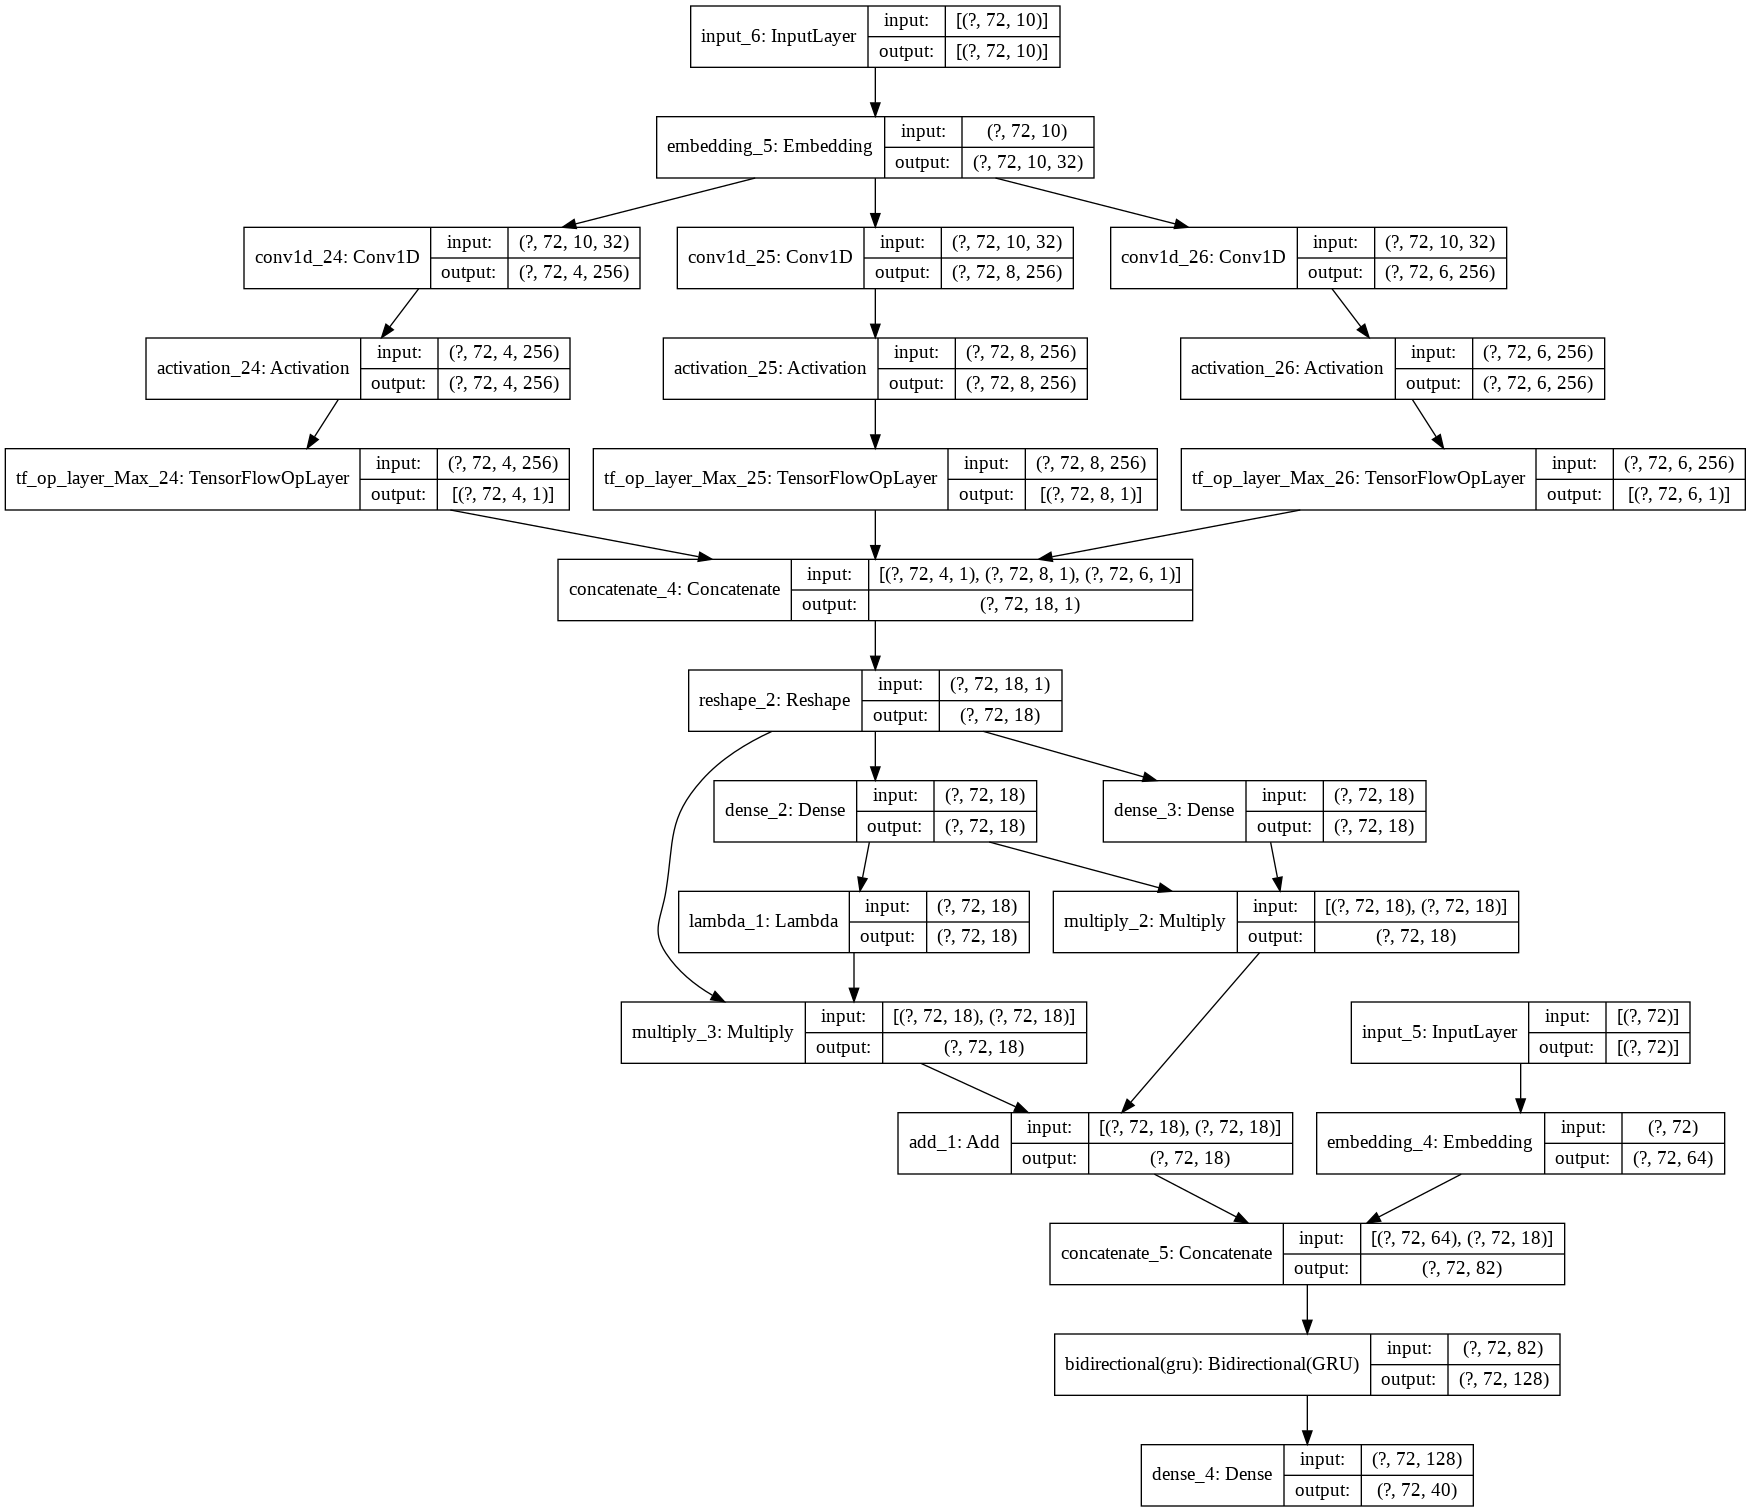

In [ ]:
k.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=k.optimizers.Adam(),
                           loss=k.losses.SparseCategoricalCrossentropy(),
                           metrics=[k.metrics.SparseCategoricalAccuracy(name='accuracy')])

model.fit(x=train_data,y=train_label, batch_size=batch, epochs=num_epochs, validation_split=0.1)

Epoch 1/10
85/85 [==============================] - 111s 1s/step - loss: 0.1367 - accuracy: 0.3466 - val_loss: 0.0679 - val_accuracy: 0.6505
Epoch 2/10
85/85 [==============================] - 109s 1s/step - loss: 0.0473 - accuracy: 0.7858 - val_loss: 0.0285 - val_accuracy: 0.8519
Epoch 3/10
85/85 [==============================] - 108s 1s/step - loss: 0.0212 - accuracy: 0.9118 - val_loss: 0.0211 - val_accuracy: 0.8803
Epoch 4/10
85/85 [==============================] - 108s 1s/step - loss: 0.0129 - accuracy: 0.9438 - val_loss: 0.0191 - val_accuracy: 0.8895
Epoch 5/10
85/85 [==============================] - 108s 1s/step - loss: 0.0094 - accuracy: 0.9543 - val_loss: 0.0187 - val_accuracy: 0.8905
Epoch 6/10
85/85 [==============================] - 108s 1s/step - loss: 0.0076 - accuracy: 0.9608 - val_loss: 0.0189 - val_accuracy: 0.8848
Epoch 7/10
85/85 [==============================] - 108s 1s/step - loss: 0.0065 - accuracy: 0.9656 - val_loss: 0.0187 - val_accuracy: 0.8902
Epoch 8/10
85

In [ ]:
eval_data = k.preprocessing.sequence.pad_sequences(test_data,padding='post',maxlen=72)
eval_label = k.preprocessing.sequence.pad_sequences(test_label,padding='post', maxlen=72)
model.evaluate(x=[eval_data,test_chars],y=eval_label)

33/33 [==============================] - 3s 92ms/step - loss: 0.0236 - accuracy: 0.8783


[0.023624608293175697, 0.8783155679702759]

In [ ]:
prediction = model.predict([eval_data, test_chars])
prediction = np.argmax(prediction, axis=-1)
prediction = [p[0][:p[1]].tolist() for p in zip(prediction, map(len, test_data))]
from sklearn import metrics

y_true = sum(test_label,[])
y_pred = sum(prediction,[])

#print(metrics.confusion_matrix(y_true, y_pred)
print(metrics.classification_report(y_true,y_pred, labels=range(len(tag_set)+1), target_names=tag_set))

              precision    recall  f1-score   support

      PRPVBP       0.00      0.00      0.00         0
         VBG       0.00      0.00      0.00         0
         POS       0.86      0.71      0.77        51
         VBD       1.00      1.00      1.00         3
          EX       0.87      0.79      0.83        77
         RBS       1.00      0.80      0.89         5
          DT       1.00      1.00      1.00         1
          VB       0.94      0.98      0.96       196
         JJR       0.88      0.87      0.88       375
          LS       1.00      0.33      0.50         6
         VBP       0.00      0.00      0.00         0
          GW       0.80      0.91      0.85       148
           X       0.00      0.00      0.00         1
        PRP$       0.00      0.00      0.00         0
          MD       0.94      0.90      0.92        70
        NNPS       0.94      1.00      0.97        34
         VBZ       0.00      0.00      0.00         1
          RP       0.96    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1989: UserWarning: labels size, 40, does not match size of target_names, 39
  .format(len(labels), len(target_names))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
